In [ ]:
import os, glob, sys
import numpy as np
import pandas as pd


## Load all the data so we explore it. 
pfile = '../Data/training_2024-11-04.pickle'
pfile_test = '../Data/testing_2024-11-04.pickle'
if os.path.isfile(pfile):
  SEPSISdat = pd.DataFrame.from_dict(pd.read_pickle(pfile))
# SEPSISdat = pd.read_excel('../Data/(new values added) final_cleared_training_data.xlsx')
# print(len(SEPSISdat.patient)) # should be n=200112

if os.path.isfile(pfile_test):
  SEPSISdat_test = pd.DataFrame.from_dict(pd.read_pickle(pfile_test))
# SEPSISdat_test = pd.read_excel('../Data/(new values added) final_cleared_testing_data.xlsx')
# print(len(SEPSISdat_test.patient)) # should be n=41993

In [ ]:
# # save data as pickle file

# SEPSISdat.to_pickle('SEPSISdat.pkl')
# SEPSISdat_test.to_pickle('SEPSISdat_test.pkl')

In [ ]:
# # load pickle files
# SEPSISdat = pd.read_pickle('SEPSISdat.pkl')
# SEPSISdat_test = pd.read_pickle('SEPSISdat_test.pkl')


# SEPSISdat.replace('#DIV/0!', pd.NA, inplace=True)
# SEPSISdat_test.replace('#DIV/0!', pd.NA, inplace=True)


In [5]:
## remove out of bound values
# Replace out-of-range values with NaN
def replace_out_of_range(data):
    # Ensure columns are float type to handle np.nan properly
    cols_to_check = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess', 'FiO2', 
                     'pH', 'BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium', 'Potassium', 
                     'Hct', 'WBC', 'Platelets']

    for col in cols_to_check:
        if col in data.columns:
            data[col] = data[col].astype(float)  # Convert to float if not already

    # Replace out-of-range values with NaN
    data.loc[(data['HR'] < 40) | (data['HR'] > 200), 'HR'] = np.nan
    data.loc[(data['O2Sat'] < 40) | (data['O2Sat'] > 100), 'O2Sat'] = np.nan
    data.loc[(data['Temp'] < 35) | (data['Temp'] > 42), 'Temp'] = np.nan
    data.loc[(data['SBP'] < 80) | (data['SBP'] > 180), 'SBP'] = np.nan
    data.loc[(data['MAP'] < 50) | (data['MAP'] > 120), 'MAP'] = np.nan
    data.loc[(data['DBP'] < 40) | (data['DBP'] > 120), 'DBP'] = np.nan
    data.loc[(data['Resp'] < 12) | (data['Resp'] > 30), 'Resp'] = np.nan
    data.loc[data['BaseExcess'] > 20, 'BaseExcess'] = np.nan
    data.loc[(data['FiO2'] < 0.2) | (data['FiO2'] > 1.1), 'FiO2'] = np.nan
    data.loc[data['pH'] < 6.75, 'pH'] = np.nan
    data.loc[data['BUN'] > 200, 'BUN'] = np.nan
    data.loc[data['Calcium'] > 25, 'Calcium'] = np.nan
    data.loc[data['Creatinine'] > 15, 'Creatinine'] = np.nan
    data.loc[data['Glucose'] > 750, 'Glucose'] = np.nan
    data.loc[data['Magnesium'] > 5, 'Magnesium'] = np.nan
    data.loc[data['Potassium'] > 10, 'Potassium'] = np.nan
    data.loc[data['Hct'] > 60, 'Hct'] = np.nan
    data.loc[data['WBC'] > 60, 'WBC'] = np.nan
    data.loc[data['Platelets'] > 750, 'Platelets'] = np.nan

    return data

SEPSISdat = replace_out_of_range(SEPSISdat)
SEPSISdat_test = replace_out_of_range(SEPSISdat_test)


In [43]:
# SEPSISdat_NOsepsis = SEPSISdat[~SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))]
# SEPSISdat_NOsepsis = SEPSISdat_NOsepsis[SEPSISdat_NOsepsis.ICULOS>1]

# SEPSISdat_sepsis = SEPSISdat[SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))]
# SEPSISdat_sepsis = SEPSISdat_sepsis[SEPSISdat_sepsis.ICULOS>1]

In [6]:
## Forward-fill missing values
SEPSISdat.update(SEPSISdat.groupby('patient').ffill())
SEPSISdat_test.update(SEPSISdat_test.groupby('patient').ffill())

## Get reference ranges for variables using only non-sepsis patients as 'normal'
SEPSISdat_NOsepsis = SEPSISdat[~SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))].copy()
SEPSISdat_NOsepsis = SEPSISdat_NOsepsis[SEPSISdat_NOsepsis.ICULOS>1].copy()


In [7]:

## Replace values still missing with the mean
SEPSISdat_NOsepsis.drop(['patient','SepsisLabel'],axis=1,inplace=True)
SEPSISdat_NOsepsis.astype('float')
meanSEPSISdat = round(SEPSISdat_NOsepsis.mean(axis=0),3)


SEPSISdat.iloc[:,1:24] = SEPSISdat.iloc[:,1:24].apply(lambda col: col.fillna(meanSEPSISdat[col.name]), axis=0)
SEPSISdat_test.iloc[:,1:24] = SEPSISdat_test.iloc[:,1:24].apply(lambda col: col.fillna(meanSEPSISdat[col.name]), axis=0)


In [8]:
## add new features
def add_new_features(data):
    """
    Adds new columns with various ratios and metrics to the dataframe.

    New predictors added:
    - SF_Ratio: SPO2/FiO2 Ratio (Surrogate of P/F ratio)
    - Shock_Index (SI): Heart Rate (HR) to Systolic Blood Pressure (SBP) ratio
    - Platelet_to_Lymphocyte_Ratio (PLR): WBC (Lymphocytes) to Platelets ratio
    - Lactate: Not possible, placeholder message
    - Estimated_Bicarbonate: Calculated bicarbonate based on PaCO2 and pH
    - DSBP_Ratio: Diastolic Blood Pressure (DBP) to Systolic Blood Pressure (SBP) ratio

    Parameters:
    data (pd.DataFrame): The input dataframe containing the relevant columns.
    
    Returns:
    pd.DataFrame: The dataframe with the added predictor columns.
    """
    
    # Ensure the required columns are present
    required_columns = ['O2Sat', 'FiO2', 'HR', 'SBP', 'WBC', 'Platelets', 'pH', 'BaseExcess', 'DBP']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {required_columns}")

    # SF_Ratio (SPO2/FiO2 Ratio)
    data['SF Ratio'] = data['O2Sat'] / data['FiO2'].replace(0, np.nan)

    # Shock Index (SI)
    data['SI'] = data['HR'] / data['SBP'].replace(0, np.nan)

    # Platelet-to-Lymphocyte Ratio (PLR)
    data['PLR'] = data['WBC'] / data['Platelets'].replace(0, np.nan)

    # Estimated Bicarbonate (using the Henderson-Hasselbalch equation)
    # Base excess is assumed to be in the 'BaseExcess' column
    data['Bicarbonate'] = 0.03 * data['PaCO2'] * (10**(data['pH'] - 6.1)) + data['BaseExcess']

    # Diastolic/Systolic Blood Pressure Ratio (D/S BP)
    data['D/S BP'] = data['DBP'] / data['SBP'].replace(0, np.nan)

    return data

SEPSISdat = add_new_features(SEPSISdat)
SEPSISdat_test = add_new_features(SEPSISdat_test)

# SEPSISdat['MAP'] = SEPSISdat['MAP']**2
# SEPSISdat['HR'] = SEPSISdat['HR']**2
# SEPSISdat['Resp'] = SEPSISdat['Resp']**2

# SEPSISdat_test['MAP'] = SEPSISdat_test['MAP']**2
# SEPSISdat_test['HR'] = SEPSISdat_test['HR']**2
# SEPSISdat_test['Resp'] = SEPSISdat_test['Resp']**2

# for col in SEPSISdat.columns[list(range(2, 23)) + list(range(26, SEPSISdat.shape[1]))]:
#         derivative_col = f"{col}_derivative"
#         SEPSISdat[derivative_col] = SEPSISdat.groupby(SEPSISdat.patient)[col].diff()

# for col in SEPSISdat_test.columns[list(range(2, 23)) + list(range(26, SEPSISdat_test.shape[1]))]:
#         derivative_col = f"{col}_derivative"
#         SEPSISdat_test[derivative_col] = SEPSISdat_test.groupby(SEPSISdat_test.patient)[col].diff()

# SEPSISdat.update(SEPSISdat.groupby('patient').bfill())
# SEPSISdat_test.update(SEPSISdat_test.groupby('patient').bfill())

In [9]:
# standardize
SEPSISdat_NOsepsis = SEPSISdat[~SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))].copy()
SEPSISdat_NOsepsis = SEPSISdat_NOsepsis[SEPSISdat_NOsepsis.ICULOS>1].copy()
SEPSISdat_NOsepsis.drop(['patient','SepsisLabel'],axis=1,inplace=True)
# SEPSISdat_NOsepsis.drop(['patient','SepsisLabel','Sex','sepsis_phase'],axis=1,inplace=True)
SEPSISdat_NOsepsis.astype('float')
meanSEPSISdat = round(SEPSISdat_NOsepsis.mean(axis=0),2)
sdSEPSISdat = round(SEPSISdat_NOsepsis.std(axis=0),2)
np.set_printoptions(suppress=True)
print('x_mean = np.array(')
print(np.array(meanSEPSISdat),')')
print('x_std = np.array(')
print(np.array(sdSEPSISdat),')')
## Obtain the z-scores for all the variables
SEPSISdat_zScores = SEPSISdat
SEPSISdat_test_zScores = SEPSISdat_test
# cols = SEPSISdat_zScores.columns.drop(['patient','SepsisLabel','Sex','sepsis_phase'])
cols = SEPSISdat_zScores.columns.drop(['patient','SepsisLabel','Sex'])
for c in cols:
  SEPSISdat_zScores[c] = (SEPSISdat_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]
  SEPSISdat_test_zScores[c] = (SEPSISdat_test_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]
## Replace values still missing with the mean
SEPSISdat_zScores = SEPSISdat_zScores.fillna(0)
SEPSISdat_test_zScores = SEPSISdat_test_zScores.fillna(0)


x_mean = np.array(
[ 22.48  83.6   97.25  36.93 122.93  81.47  62.97  18.42  -0.47   0.5
   7.39  40.32  20.42   7.82   1.33 131.06   2.04   4.14  31.46  10.58
  11.4  195.5   62.25   0.58 204.06   0.7    0.07  22.95   0.52] )
x_std = np.array(
[15.22 16.45  2.81  0.65 20.78 14.21 11.88  4.08  2.    0.12  0.04  5.25
 14.32  1.75  1.33 39.87  0.3   0.5   4.85  1.68  4.49 80.09 15.82  0.49
 47.91  0.19  0.05  4.46  0.1 ] )


In [10]:

y = SEPSISdat_zScores.SepsisLabel
#[(SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1])))]
X = SEPSISdat_zScores.copy()
# X = X.iloc[:,1:24]
X.drop(['patient','SepsisLabel'],axis=1,inplace=True)
# 'ICULOS','SBP','DBP','FiO2','PaCO2','Hct','Hgb','Calcium','Magnesium','Potassium',
y_test = SEPSISdat_test_zScores.SepsisLabel
X_test = SEPSISdat_test_zScores.copy()
# X_test = X_test.iloc[:,1:24]
X_test.drop(['patient','SepsisLabel'],axis=1,inplace=True)


In [18]:
# resample
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data and generate synthetic examples
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution before and after resampling
print(f"Original class distribution: {pd.Series(y).value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_resampled).value_counts()}")

Original class distribution: 0.0    194809
1.0      5303
Name: SepsisLabel, dtype: int64
Resampled class distribution: 0.0    194809
1.0    194809
Name: SepsisLabel, dtype: int64


In [ ]:
t.drop(['patient','SepsisLabel','sepsis_phase','FiO2','SBP','Hgb','Calcium','Magnesium','Potassium','Sex'],axis=1,inplace=True)


In [25]:
#### OPTION 1: LOGISTIC REGRESSION ####
## Build a logistic regression using all the training data

from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=42,penalty='l1',solver='liblinear')
lreg.fit(X_resampled,y_resampled)
print('const=',np.round(lreg.intercept_,4))
print('coeffs = np.array(')
print(np.round(lreg.coef_,4),')')


const= [-0.4919]
coeffs = np.array(
[[ 0.2291 -0.1054  0.067   0.3169  0.255  -0.2504  0.0391  0.1187  0.3642
   0.0551  0.2537  0.3964  0.1826 -0.0607  0.0692  0.0841 -0.0367 -0.1771
  -0.183   0.197   0.0686  0.1256 -0.0356 -0.0752  0.2932  0.0676 -0.672
   0.0281  0.06   -0.0123  0.0081 -0.1229  0.0491  0.0153 -0.0425 -0.0748
   0.0363 -0.0635 -0.094   0.0508 -0.0279 -0.0081 -0.0346  0.      0.0258
   0.0437 -0.0555  0.0209 -0.0564  0.0206 -0.1109 -0.0076  0.1254 -0.0191]] )


In [26]:

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
# X = X.assign(probSepsisLR=lreg.predict_proba(X.iloc)[::,1])
# X_test = X_test.assign(probSepsisLR=lreg.predict_proba(SEPSISdat_test_zScores.iloc[:,1:24])[::,1])
y_prob = lreg.predict_proba(X)[:,1]
y_test_prob = lreg.predict_proba(X_test)[:,1]
#print(SEPSISdat_zScores)


AUC: 0.746
AUC_test: 0.72
thresh= 0.4898


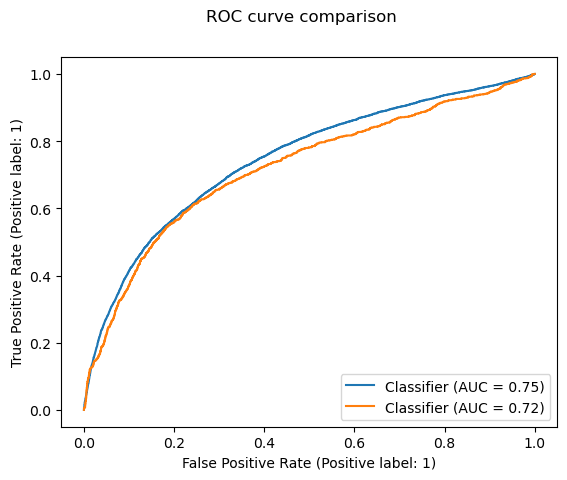

In [27]:

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")
print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('thresh=',thresh)

In [28]:
# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

100%|██████████| 5000/5000 [02:18<00:00, 36.20it/s]


0.3548


100%|██████████| 1000/1000 [00:08<00:00, 112.13it/s]

0.3082


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5303, number of negative: 194809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5430
[LightGBM] [Info] Number of data points in the train set: 200112, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026500 -> initscore=-3.603747
[LightGBM] [Info] Start training from score -3.603747


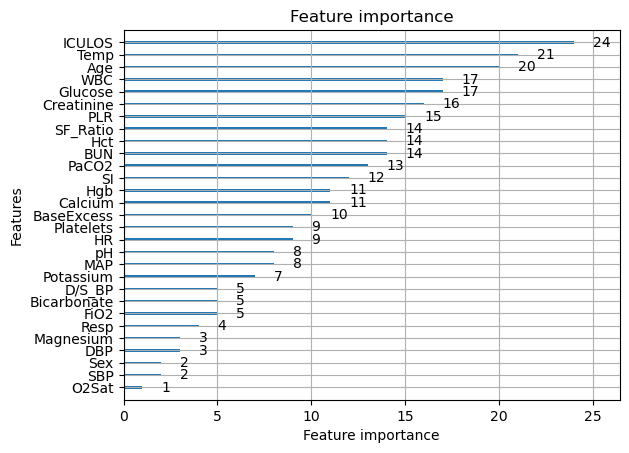

In [11]:
#### OPTION 2: BOOSTED TREE #####
## Build a LightGBM model using all the training data
from sklearn.feature_selection import RFE
import lightgbm as lgb
train_data = lgb.Dataset(data=X, label=y)
param = {'objective': 'binary'}
bst = lgb.train(param, train_data, 10)
imp = lgb.plot_importance(bst)


In [12]:

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
y_prob = bst.predict(data=X)
y_test_prob = bst.predict(data=X_test)


AUC: 0.848
AUC_test: 0.752
Threshold: 0.0319


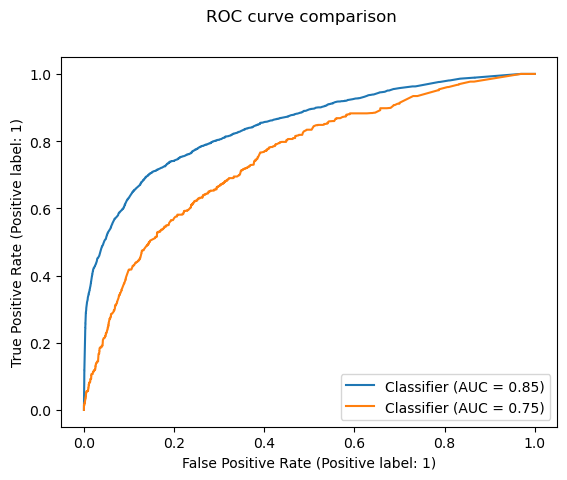

In [14]:

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))

# Save the model and get the threshold for use as a model
bst.save_model('lightgbm.model')
thresh=round(thresholds[np.argmax(tpr-fpr)],4)

print('Threshold:',thresh)

In [15]:
# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
# util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
# print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

100%|██████████| 1000/1000 [00:04<00:00, 203.85it/s]

0.3422


AttributeError: module 'lightgbm' has no attribute 'feature_importance'

In [ ]:
## OPTION 4: Support Vector Machine ##
exit(0)
from sklearn import svm
clf = svm.LinearSVC(max_iter=3000)
clf.fit(X,y)

## Add the predictions
y_prob = clf.predict(X)
y_test_prob = clf.predict(X_test)

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, y_prob)
print('AUC:',round(roc_auc_score(y,y_prob),2))
print('AUC_test:',round(roc_auc_score(y_test, y_test_prob),2))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

# # Quick calculation of utility score
# SEPSISdat = SEPSISdat.assign(SepsisLabelSVM = (SEPSISdat_zScores.probSepsisSVM>thresh).astype(int))
# SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelSVM = (SEPSISdat_test_zScores.probSepsisSVM>thresh).astype(int))

# import evaluate_sepsis_score as ev
# util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelSVM))
# print(util)
# util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelSVM))
# print(util_test)

# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

AUC: 0.5
AUC_test: 0.5
Threshold: inf


 64%|██████▎   | 3183/5000 [01:59<01:08, 26.67it/s]


KeyboardInterrupt: 

: 

AUC: 0.512
AUC_test: 0.507


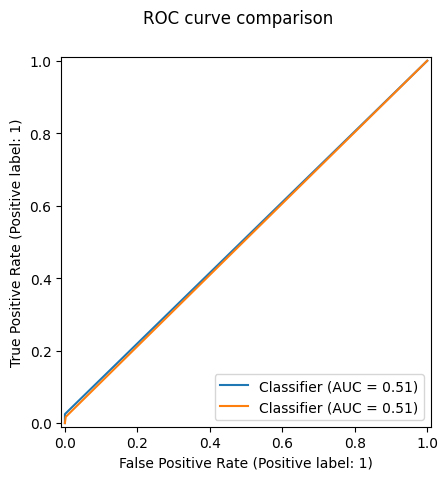

: 

In [ ]:
## OPTION 3: KNN Classifier ##
exit(0)
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X,y)

## Add the predictions
y_prob=model.predict(X)
y_test_prob = model.predict(X_test)

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))

In [ ]:
# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelKNN = (SEPSISdat_zScores.probSepsisKNN>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelKNN = (SEPSISdat_test_zScores.probSepsisKNN>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelKNN))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelKNN))
print(util_test)

In [40]:
#### Random Forest ####
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE

rf = RandomForestClassifier()
# rfe = RFE(estimator=rf, n_features_to_select=10)
# rfe.fit(X, y)

# # Get selected features
# selected_features = X.columns[rfe.support_]
# X_selected = X[selected_features]
# X_test_selected = X_test[selected_features]
rf.fit(X_resampled,y_resampled)
imp = rf.feature_importances_
for i in range(len(X.columns)):
    print(f"importance of '{X.columns[i]}': {imp[i]}")


importance of 'ICULOS': 0.13840888495816567
importance of 'HR': 0.03702209083998686
importance of 'O2Sat': 0.03282444208606455
importance of 'Temp': 0.06567100932582629
importance of 'SBP': 0.023318083080422023
importance of 'MAP': 0.02291075692097751
importance of 'DBP': 0.024890872269053326
importance of 'Resp': 0.039539898742918696
importance of 'BaseExcess': 0.03468592999911171
importance of 'FiO2': 0.04089283462951326
importance of 'pH': 0.03911871353035935
importance of 'PaCO2': 0.03513749893009678
importance of 'BUN': 0.05299998921817233
importance of 'Calcium': 0.038166649487363875
importance of 'Creatinine': 0.045898789463780655
importance of 'Glucose': 0.036681032923342696
importance of 'Magnesium': 0.03299480909204359
importance of 'Potassium': 0.03945322228349032
importance of 'Hct': 0.03629742989143925
importance of 'Hgb': 0.03712361017845521
importance of 'WBC': 0.045174126143606066
importance of 'Platelets': 0.04647138187814981
importance of 'Age': 0.054317944127660105


In [41]:

ranked_features = X.columns[np.argsort(imp)[::-1]]
print(ranked_features)

Index(['ICULOS', 'Temp', 'Age', 'BUN', 'Platelets', 'Creatinine', 'WBC',
       'FiO2', 'Resp', 'Potassium', 'pH', 'Calcium', 'Hgb', 'HR', 'Glucose',
       'Hct', 'PaCO2', 'BaseExcess', 'Magnesium', 'O2Sat', 'DBP', 'SBP',
       'MAP'],
      dtype='object')


In [42]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize variables
cv_scores = []
top_features = []

# Iterate through increasing numbers of features
for i in range(1, len(ranked_features) + 1, 5):
    selected = ranked_features[:i]
    X_subset = X.loc[:, selected]
    
    # Perform cross-validation with the selected features
    model = RandomForestClassifier(class_weight='balanced')
    scores = cross_val_score(model, X_subset, y, cv=5, scoring='recall')  # Adjust scoring as needed
    cv_scores.append(np.mean(scores))
    print(f"{i} features: {np.mean(scores)}")

# Find optimal number of features
optimal_features = np.argmax(cv_scores) + 1
print(f"Optimal number of features: {optimal_features}")

# Train final model with optimal features
final_features = ranked_features[:optimal_features]
X_final = X[:, final_features]
final_model = RandomForestClassifier(random_state=42,class_weight='balanced').fit(X_final, y)

1 features: 0.48123966354275965
6 features: 0.01640549143741219
11 features: 0.00603417921860829
16 features: 0.006034534881653121
21 features: 0.0030178009353938077
Optimal number of features: 1


InvalidIndexError: (slice(None, None, None), Index(['ICULOS'], dtype='object'))

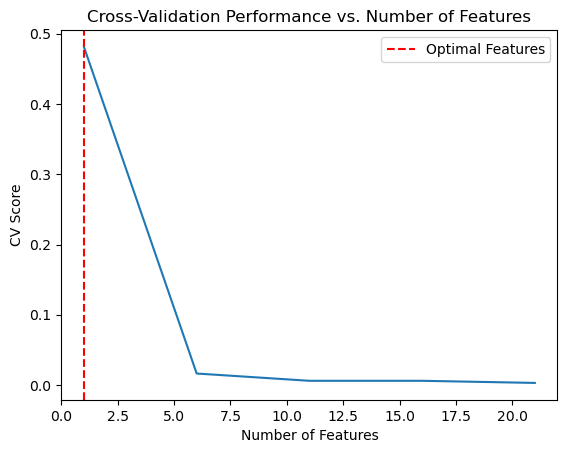

In [43]:
# plot Feature Selection Curve
import matplotlib.pyplot as plt

plt.plot(range(1, len(cv_scores)*5 + 1,5), cv_scores)
plt.xlabel("Number of Features")
plt.ylabel("CV Score")
plt.title("Cross-Validation Performance vs. Number of Features")
plt.axvline(optimal_features, color='red', linestyle='--', label='Optimal Features')
plt.legend()
plt.show()

In [ ]:


param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample', None],
}

grid_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_iter=10)
grid_search.fit(X_selected, y)
print(grid_search.best_params_)


AUC: 1.0
AUC_test: 0.758
Threshold: 0.57


100%|██████████| 5000/5000 [01:42<00:00, 49.01it/s]


0.8838


100%|██████████| 1000/1000 [00:04<00:00, 210.79it/s]


0.0077


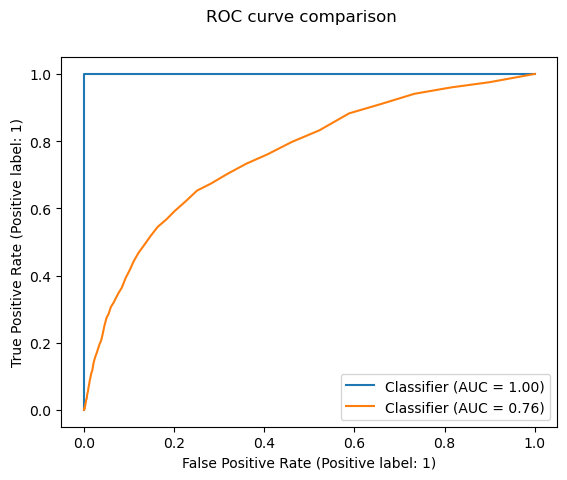

In [44]:

y_prob = rf.predict_proba(X)[:,1]
y_test_prob = rf.predict_proba(X_test)[:,1]


## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))


# Save the model and get the threshold for use as a model
# rf.save_model('lightgbm.model')
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

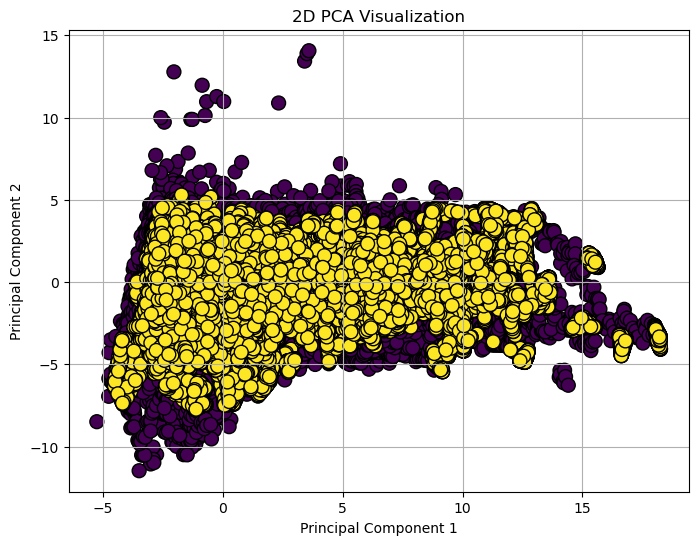

In [24]:
#### PCA ####
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_resampled)

# Plot the PCA results in 2D
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='viridis', edgecolor='k', s=100)

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.grid(True)
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import evaluate_sepsis_score as ev
import numpy as np

# Initialize the model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# Train the model
rf_clf.fit(SEPSISdat_zScores.iloc[:, 1:24], SEPSISdat_zScores.SepsisLabel)

# Add predictions
SEPSISdat_zScores = SEPSISdat_zScores.assign(probSepsisRF=rf_clf.predict_proba(SEPSISdat_zScores.iloc[:, 1:24])[:, 1])
SEPSISdat_test_zScores = SEPSISdat_test_zScores.assign(probSepsisRF=rf_clf.predict_proba(SEPSISdat_test_zScores.iloc[:, 1:24])[:, 1])

# Calculate AUC and threshold
fpr, tpr, thresholds = roc_curve(SEPSISdat_zScores.SepsisLabel, SEPSISdat_zScores.probSepsisRF)
print('Random Forest AUC:', round(roc_auc_score(SEPSISdat_zScores.SepsisLabel, SEPSISdat_zScores.probSepsisRF), 2))
print('Random Forest AUC (Test):', round(roc_auc_score(SEPSISdat_test_zScores.SepsisLabel, SEPSISdat_test_zScores.probSepsisRF), 2))
thresh = round(thresholds[np.argmax(tpr - fpr)], 4)
print('Optimal Threshold (Random Forest):', thresh)

# Apply threshold
SEPSISdat = SEPSISdat.assign(SepsisLabelRF=(SEPSISdat_zScores.probSepsisRF > thresh).astype(int))
SEPSISdat_test = SEPSISdat_test.assign(SepsisLabelRF=(SEPSISdat_test_zScores.probSepsisRF > thresh).astype(int))

# Evaluate utility
util_rf = ev.evaluate_utility(SEPSISdat.patient, np.array(SEPSISdat_zScores.SepsisLabel), np.array(SEPSISdat.SepsisLabelRF))
print('Utility Score (Training - Random Forest):', util_rf)
util_rf_test = ev.evaluate_utility(SEPSISdat_test.patient, np.array(SEPSISdat_test_zScores.SepsisLabel), np.array(SEPSISdat_test.SepsisLabelRF))
print('Utility Score (Test - Random Forest):', util_rf_test)

Random Forest AUC: 1.0
Random Forest AUC (Test): 0.74
Optimal Threshold (Random Forest): 0.56


100%|██████████| 5000/5000 [02:00<00:00, 41.54it/s]


Utility Score (Training - Random Forest): 0.8832


100%|██████████| 1000/1000 [00:08<00:00, 116.55it/s]

Utility Score (Test - Random Forest): -0.0002


In [ ]:
#### data wrangling ####

